### Procedimiento con espacio en escala de grises:

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [31]:
img = cv2.imread('image_1.png')
img_mask=cv2.imread('image_1_mask.png')

#img = cv2.imread('image_2.png')
#img_mask=cv2.imread('image_2_mask.png')

#img = cv2.imread('image_3.png')
#img_mask=cv2.imread('image_3_mask.png')

In [32]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask_seg=cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

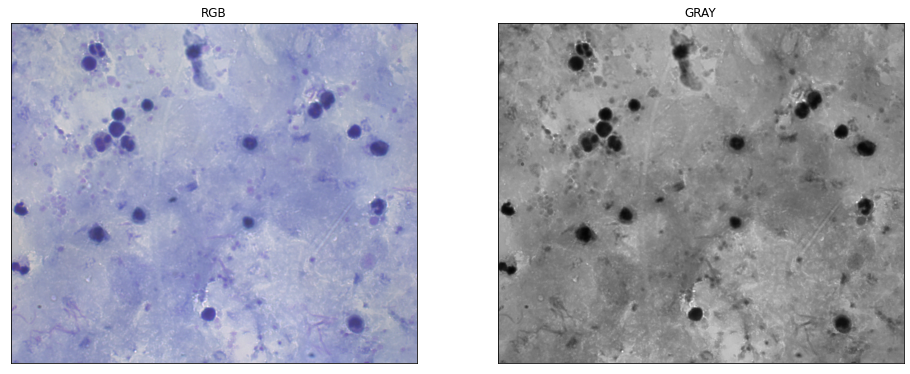

In [33]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('RGB')
plt.imshow(img_rgb)
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.title('GRAY')
plt.imshow(img_gray, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


El espacio de color con el que se va a trabajar es escala de grises es decir img_gray dado que da una imagen mas clara, acá se pueden ver los leucocitos con mayor intensidad en negro y se diferencia el fondo de los leucocitos, siendo el fondo el ruido que queremos quitar de la imagen.

A continuación, lo que se quiere realizar es agrandar los leucocitos, se realiza un **erode** y no un dilate porque la imagen tiene mas pixeles de fondo, por lo que usar un dilate hace que el fondo se dilate y se minimice el tamaño de los leucocitos. Como se observa en la siguiente imagen se hace un erode de un MORPH_ELLIPSE de 7x7 de 3 iteraciones, donde en la imagen erosionada se ve como aumenta el tamaño de los leucocitos, esto nos ayudara mas adelante a otros filtros que se van a realizar.

In [34]:
kernel1=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
erosion1= cv2.erode(img_gray, kernel1, iterations=3)

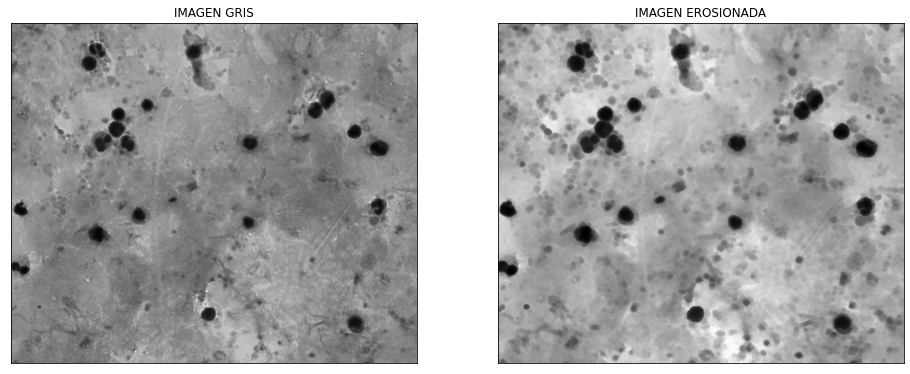

In [35]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('IMAGEN GRIS')
plt.imshow(img_gray, cmap='gray')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.title('IMAGEN EROSIONADA')
plt.imshow(erosion1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


En la imagen erosionada así como agranda los leucocitos, se agrandan otros pequeños detalles de la imagen gris.

En el siguiente paso se quita el ruido del fondo. El kernel es una multiplicación de matriz que hace por cada pixel, coge su vecindad y los promedia, para este filtro el promedio ponderado es de 0.11111111.

In [36]:
kernel2=np.ones((5,5), np.float32)/9
filtro2= cv2.filter2D(erosion1, -1, kernel2)

In [37]:
kernel2

array([[0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111]],
      dtype=float32)

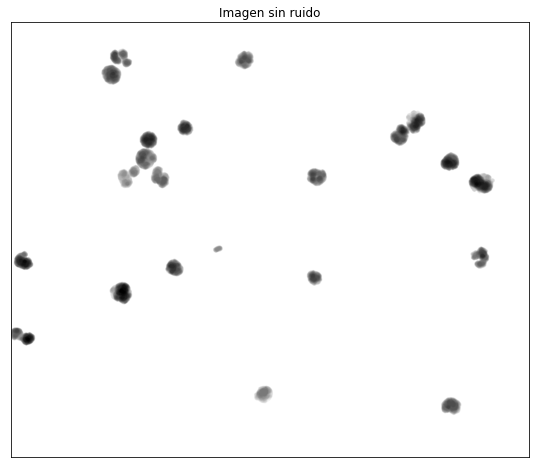

In [38]:
plt.figure(figsize=(16, 8))
plt.title('Imagen sin ruido')
plt.imshow(filtro2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


Como se observa en la imagen anterior, el fondo queda en blanco, se quito el ruido y quedan solo los leuocitos en escala de grises y negro.

Se realiza un histograma con la finalidad de ver en que escala esta la imagen anterior, como se observa estan picos de 0 y 255 por tener mayor cantidad de pixeles en esos valores, y pocos valores por debajo de 255, que representan algunos grises, de los cuales se pretende volver negros completamente para que se puedan observar con mas intensidad.

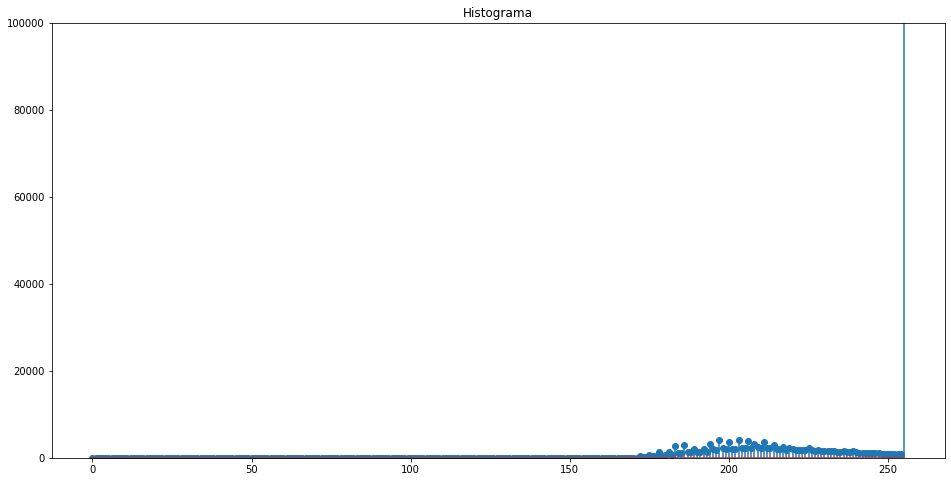

In [39]:
hist_gray = cv2.calcHist([filtro2], [0], None, [256], [0, 256])

plt.figure(figsize=(16,8))
plt.title('Histograma')
plt.ylim([0, 1e5])
plt.stem(hist_gray)
plt.show()

Se establece manualmente 240, para dejar la imagen en blanco y negro.

In [40]:
filtro2[filtro2<240]=0

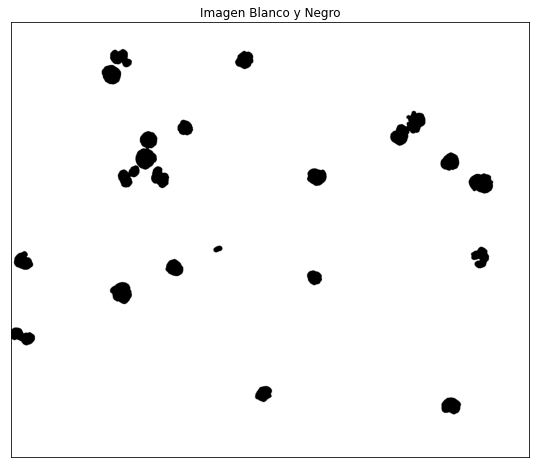

In [41]:
plt.figure(figsize=(16, 8))
plt.title('Imagen Blanco y Negro')
plt.imshow(filtro2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Luego de tener la imagen mas nitida, con los leucocitos completamente negros, se va a realizar un dilate, como ya se ha mencionado el dilate va a disminuir el tamaño de los leucocitos porque el fondo tiene la mayoría de pixeles.

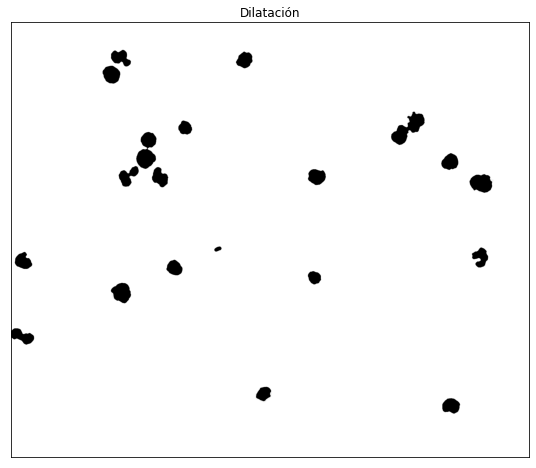

In [42]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
objects3 = cv2.dilate(filtro2, kernel3, iterations=2)

plt.figure(figsize=(16, 8))
plt.title('Dilatación')
plt.imshow(objects3, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

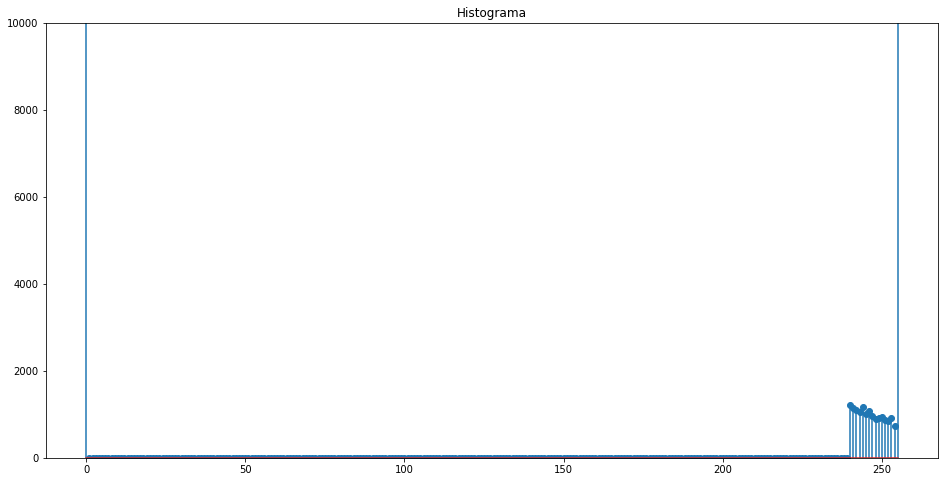

In [43]:
hist_gray2 = cv2.calcHist([objects3], [0], None, [256], [0, 256])

plt.figure(figsize=(16,8))
plt.title('Histograma')
plt.ylim([0, 1e4])
plt.stem(hist_gray2)
plt.show()

Se observa en el histograma anterior como se cambiaron los valores por debajo de 240. Posteriormente para hallar la mascara se hace una umbralización manual, y se toma un valor por de bajo de 240, como se observa a continuación se determina un T=235, se intento usar OTSU sin embargo como la imagen es blanca y negra es mas eficiente no usarlo y solo usar el THRESH_BINARY_INV.

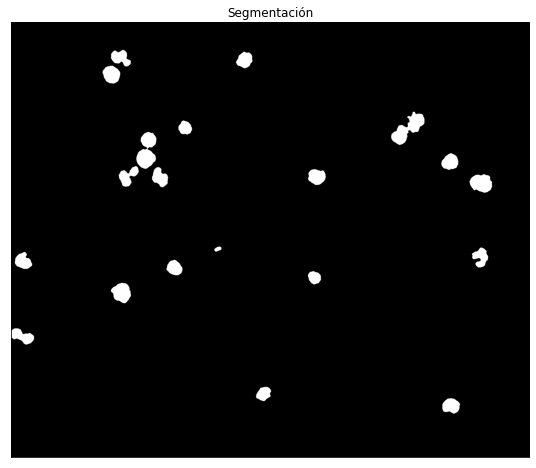

In [44]:
T=235
[_, mask1]=cv2.threshold(objects3, T, 255, cv2.THRESH_BINARY_INV)


plt.figure(figsize=(16,8))
plt.title('Segmentación')
plt.imshow(mask1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Con la mascara hecha, vamos a dilatar un poco, no hacer este paso implicaría mejorar el indice de Jaccard para la imagen 1 y 3, sin embargo bajaria para la imagen 2, y en promedio sin este paso el indice de jaccard quedaria en 77.74, pero con esta dilatación el indice de jaccard en promedio de las tres imagenes sube ligeramente a 77.81

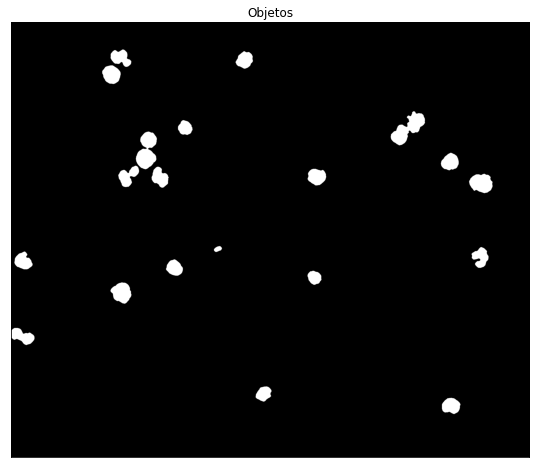

In [45]:
kernel4=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
objects4= cv2.dilate(mask1, kernel4, iterations=2)

plt.figure(figsize=(16,8))
plt.title('Objetos')
plt.imshow(objects4, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Para separar un poco los leucocitos d ela imagen hacemos una apertura de 5x5, la diferencia es poca pero ayuda a separar un poco los pixeles que une a los leucocitos.

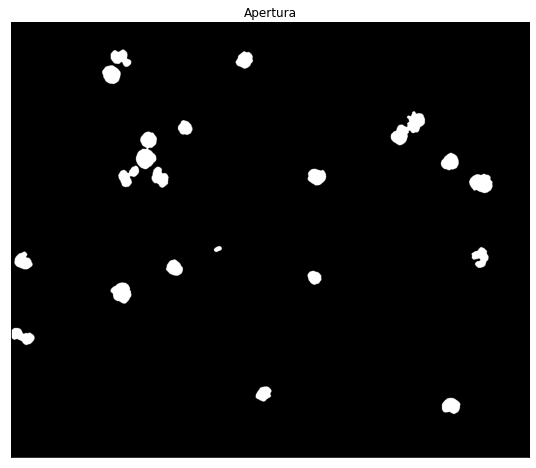

In [46]:
kernel5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
img_gray_close5= cv2.morphologyEx(objects4, cv2.MORPH_OPEN, kernel5, iterations=1)

plt.figure(figsize=(16,8))
plt.title('Apertura')
plt.imshow(img_gray_close5, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Ahora para desarrollar el background, primero cogemos las mascara encontrada y le hacemos morfología, primero con una apertura de 4 iteraciones, y luego una dilatación de 5x5 con 4 iteraciones así el background abarca la mayor cantidad de la imagen original.

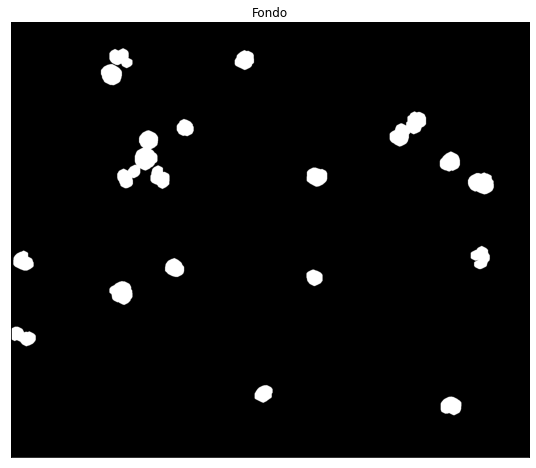

In [47]:
kernel6=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
background= cv2.morphologyEx(mask1, cv2.MORPH_OPEN, kernel6, iterations=4)

kernel_b=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
background1= cv2.dilate(background, kernel_b, iterations=4)

plt.figure(figsize=(16,8))
plt.title('Fondo')
plt.imshow(background1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Usamos la mascara final y el background anterior para mirar la región compartida como se muestra en la siguiente imagen.

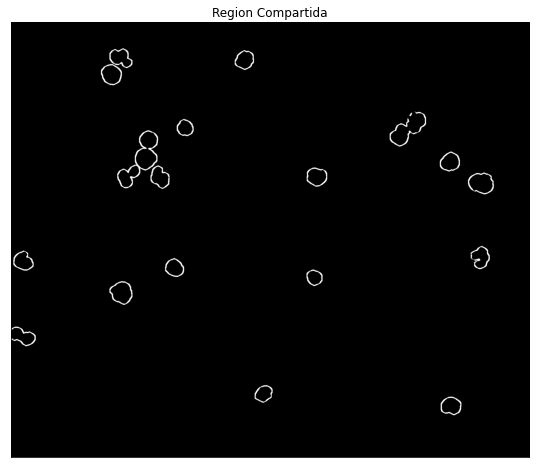

In [48]:
unknown= cv2.subtract(background1, img_gray_close5)

plt.figure(figsize=(16,8))
plt.title('Region Compartida')
plt.imshow(unknown, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [49]:
[cnt, markers] = cv2.connectedComponents(img_gray_close5)
print("Cantidad de objetos: ", cnt)

Cantidad de objetos:  21


Con la ultima imagen antes de hallar el background se realizo morfologia para separar los objetos, aqui se cuenta el numero de objetos hallados por cada imagen.

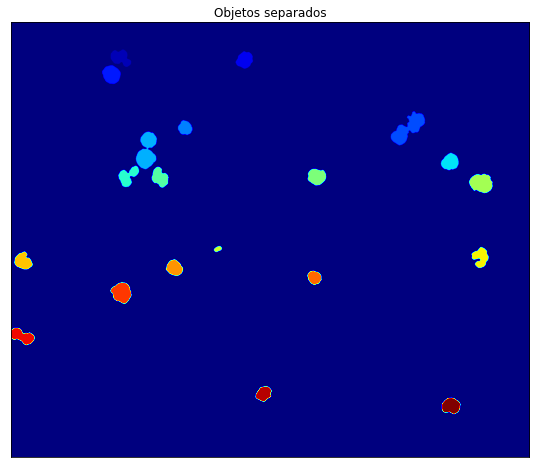

In [50]:
plt.figure(figsize=(16,8))
plt.title('Objetos separados')
plt.imshow(markers, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

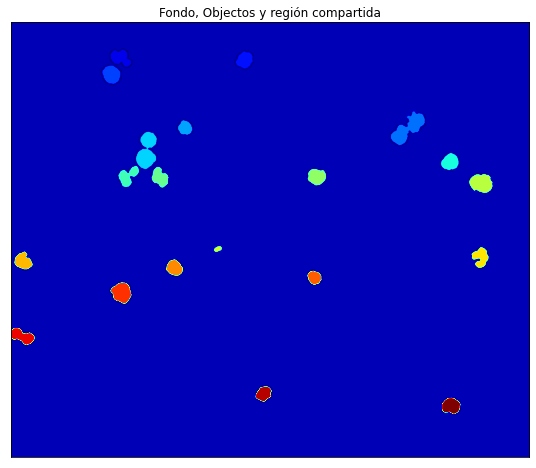

In [51]:
markers = markers+1
markers[unknown==255] = 0

plt.figure(figsize=(16,8))
plt.title('Fondo, Objectos y región compartida')
plt.imshow(markers, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()


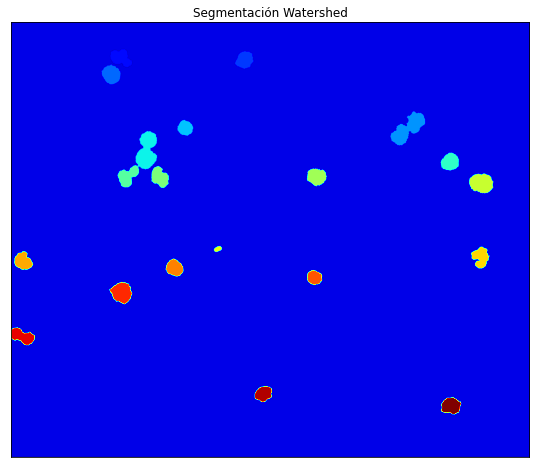

In [52]:
markers_new= cv2.watershed(img_rgb, markers)
markers_new = markers_new -1


plt.figure(figsize=(16,8))
plt.title('Segmentación Watershed')
plt.imshow(markers_new, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

Necesitamos hacer la segmentación watershed para poder determinar las mascaras de acuerdo a la cantidad de objetos hallados anteriormente mediante la variable cnt. Guardamos todas las mascaras de la imagen en mask_t2 exceptuando el fondo.

In [53]:
x=range(1,cnt)
mask_t2=0
for i in x:
    mask_t2+=np.uint8(markers_new==i)


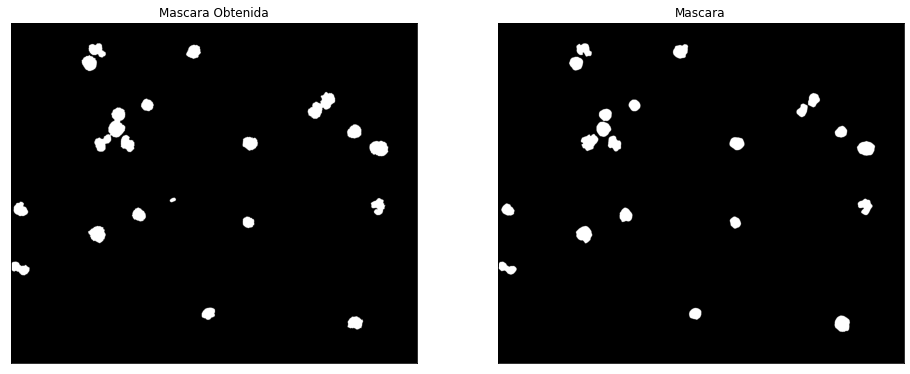

In [58]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('Mascara Obtenida')
plt.imshow(mask_t2, cmap='gray')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.title('Mascara')
plt.imshow(mask_seg, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Ya por ultimo se trae la mascara dada, se preprocesa con OTSU para posteriormente comparar en el indice de jaccard.

In [55]:
[_, mask_seg]= cv2.threshold(mask_seg, 0,1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [56]:
from sklearn.metrics import jaccard_score

In [57]:
J = jaccard_score(mask_t2, mask_seg, average='micro')
print("Indice de Jaccard: ", J*100, "%")

Indice de Jaccard:  81.0011270451984 %


*Imagen 1*, Indice de Jaccard: 81%


*Imagen 2*, Indice de Jaccard:  74.54%


*Imagen 3*, Indice de Jaccard: 77.89%

El promedio de las tres es de **77.81%**